In [1]:
# IMPORTING REQUIRED LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

DATA ANALYSIS

In [2]:
data=pd.read_csv('u.data',sep='\t',names=['user id','item id','rating','timestamp'])

In [3]:
data.head(2)

,user id,item id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742


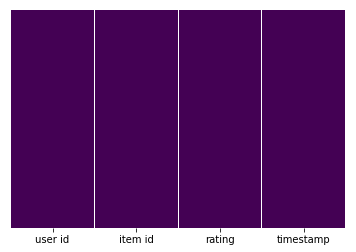

In [4]:
sns.heatmap(data.isnull(),cmap='viridis',cbar=False,yticklabels=False)

In [5]:
info=pd.read_csv('u.info',names=['value','Info'],sep=' ')

In [6]:
info.head()

,value,Info
0,943,users
1,1682,items
2,100000,ratings


In [7]:
head=['item id','title','release date','video release date','IMDb URL','unknown','Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']
items=pd.read_csv('u.item',sep='|',names=head,encoding='latin')

In [8]:
items.head(2)

,item id,title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0


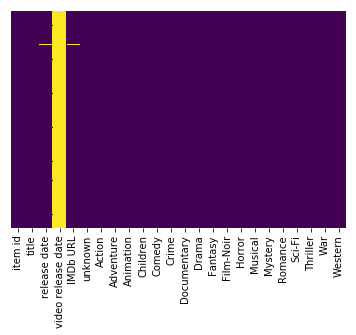

In [9]:
sns.heatmap(items.isnull(),cmap='viridis',cbar=False,yticklabels=False)

In [10]:
items.drop(['video release date'],inplace=True,axis=1)

In [11]:
users=pd.read_csv('u.user',sep='|',names=['user id','age','gender','occupation','zip code'])

In [12]:
users.head(2)

,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043


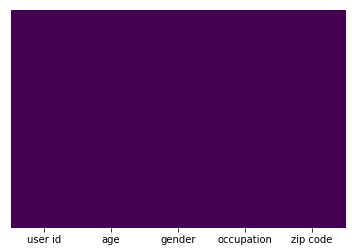

In [13]:
sns.heatmap(users.isnull(),cmap='viridis',cbar=False,yticklabels=False)

In [14]:
occupation=pd.read_csv('u.occupation',names=['List'])

In [15]:
data.head(2)

,user id,item id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742


In [17]:
# SPLITTING GIVEN DATASET INTO TRAIN AND TEST DATASET

from sklearn import cross_validation as cv
train,test=cv.train_test_split(data,test_size=0.3)

In [18]:
data.head(2)

,user id,item id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742


In [19]:
# CREATING USER-ITEM MATRIX FROM THE ORIGINAL DATAFRAME

trainmatrix=np.zeros((data['user id'].nunique(),data['item id'].nunique()))
testmatrix=np.zeros((data['user id'].nunique(),data['item id'].nunique()))

for i in train.itertuples():
    trainmatrix[i[1]-1][i[2]-1]=i[3]

for i in test.itertuples():
    testmatrix[i[1]-1][i[2]-1]=i[3]

In [20]:
trainmatrix

array([[ 5.,  3.,  0., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.]])

In [21]:
testmatrix

array([[ 0.,  0.,  4., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

MEMORY-BASED COLLABORATIVE FILTERING

In [22]:
from sklearn.metrics import pairwise_distances as pwd

In [23]:
similar_user=pwd(trainmatrix,metric='cosine')
similar_item=pwd(trainmatrix.T,metric='cosine')

In [24]:
similar_user

array([[ 0.        ,  0.87654547,  0.96949176, ...,  0.8855922 ,
         0.89622051,  0.67128039],
       [ 0.87654547,  0.        ,  0.91893994, ...,  0.89230411,
         0.82949525,  0.92427713],
       [ 0.96949176,  0.91893994,  0.        , ...,  0.93525372,
         0.9065139 ,  0.96269233],
       ..., 
       [ 0.8855922 ,  0.89230411,  0.93525372, ...,  0.        ,
         0.92736547,  0.91886396],
       [ 0.89622051,  0.82949525,  0.9065139 , ...,  0.92736547,
         0.        ,  0.8550093 ],
       [ 0.67128039,  0.92427713,  0.96269233, ...,  0.91886396,
         0.8550093 ,  0.        ]])

In [25]:
# Here mean_user_rating is calculated in order to Normalise the User Rating.

def predict(ratings,similarity,type='user'):
    if type=='user':
        mean_user_rating=ratings.mean(axis=1)
        ratings_diff=(ratings-mean_user_rating[:,np.newaxis])
        pred=mean_user_rating[:,np.newaxis]+similarity.dot(ratings_diff)/np.array([np.abs(similarity).sum(axis=1)]).T
    else:
        pred=ratings.dot(similarity)/np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [26]:
item_prediction=predict(trainmatrix,similar_item,type='item')
user_prediction=predict(trainmatrix,similar_user,type='user')

EVALUATION BY CALCULATING ROOT MEAN SQUARED ERROR (RMSE)

In [27]:
from sklearn.metrics import mean_squared_error as mse
from math import sqrt

In [29]:
prediction=user_prediction[testmatrix.nonzero()].flatten()
original=testmatrix[testmatrix.nonzero()].flatten()
user_based_error=sqrt(mse(prediction,original))

In [30]:
print(user_based_error)

3.1580344523911354


In [31]:
prediction=item_prediction[testmatrix.nonzero()].flatten()
original=testmatrix[testmatrix.nonzero()].flatten()
item_based_error=sqrt(mse(prediction,original))

In [32]:
print(item_based_error)

3.4625820911814804
